# Outline
* load image
* concat
* load event tsv
* concat
* first level with fir

TODO: add csf and white matter
TODO: plot timeseries

https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_predictions_residuals.html

In [194]:
from os.path import join
import os, glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from nilearn.plotting import plot_event
from nilearn import glm, image, plotting, maskers, masking
from nilearn.datasets import (load_mni152_template)

In [39]:
fmriprep_dir = '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/'
sub = 'sub-0002'
beh_dir = f'/Users/h/Documents/projects_local/sandbox/fmriprep_bold/{sub}/beh'
# onset_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/data/fmri/fmri01_onset/onset02_SPM'
onset_dir = f'/Users/h/Documents/projects_local/sandbox/fmriprep_bold/{sub}/onset'


In [ ]:
flist = sorted(glob.glob(join(fmriprep_dir, sub, 'func', 'sub-0002_ses-01_task-social_acq-mb8_run-*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii'), recursive=True))

In [25]:
flist

['/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0002/func/sub-0002_ses-01_task-social_acq-mb8_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii',
 '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0002/func/sub-0002_ses-01_task-social_acq-mb8_run-4_space-MNI152NLin2009cAsym_desc-preproc_bold.nii',
 '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0002/func/sub-0002_ses-01_task-social_acq-mb8_run-5_space-MNI152NLin2009cAsym_desc-preproc_bold.nii',
 '/Users/h/Documents/projects_local/sandbox/fmriprep_bold/sub-0002/func/sub-0002_ses-01_task-social_acq-mb8_run-6_space-MNI152NLin2009cAsym_desc-preproc_bold.nii']

In [92]:
fmri_img = [image.load_img(fname) for fname in flist]

In [29]:
# from the bold images, load in the corresopnding onset files
import re


pattern = r'sub-(\d+)_ses-(\d+)_task-\w+_acq-\w+_run-(\d+)_space-\w+_desc-\w+\.nii'
data_dict = {"sub": [], "ses": [], "run": []}

for file_path in flist:
    match = re.search(pattern, os.path.basename(file_path))
    if match:
        sub_num, ses_num, run_num = match.groups()
        data_dict["sub"].append(f"sub-{sub_num}")
        data_dict["ses"].append(f"ses-{ses_num}")
        data_dict["run"].append(run_num)

print(data_dict)


{'sub': ['sub-0002', 'sub-0002', 'sub-0002', 'sub-0002'], 'ses': ['ses-01', 'ses-01', 'ses-01', 'ses-01'], 'run': ['1', '4', '5', '6']}


In [42]:
# fname = join(onset_dir, f'{sub}_ses-01_task-cue_run-01_runtype-pain_events.tsv')
fname = join(beh_dir, f'{sub}_ses-01_task-cue_acq-mb8_run-01_events.tsv')
event_df = pd.read_csv(fname)

In [44]:
event_df['condition_type'] = event_df['cuetype'].astype(str) +'_' + event_df['stimtype'].astype(str)

In [161]:
sub = data_dict["sub"][0]
ses = data_dict["ses"][0]

tr = 0.46  # repetition time is 1 second
n_scans = 872  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times


design_matrices = []
event_concat = []
confounds_concat = []
for run_num in data_dict["run"]:
    # load file and reconstruct column "condition_type"
    fname = join(beh_dir, f'{sub}_{ses}_task-cue_acq-mb8_run-{int(run_num):02d}_events.tsv')
    event_df = pd.read_csv(fname)
    event_df['condition_type'] = event_df['cuetype'].astype(str) +'_' + event_df['stimtype'].astype(str)
    # create events dictionary for nilearn
    events = pd.DataFrame(
        {
            "trial_type": event_df[event_df['trial_type']=='stimulus'].condition_type, #trial_types,
            "onset": event_df[event_df['trial_type']=='stimulus'].onset, #onsets,
            "duration": event_df[event_df['trial_type']=='stimulus'].duration #durations,
        }
    )
    confounds_fname = join(fmriprep_dir,sub, 'func', f'{sub}_{ses}_task-social_acq-mb8_run-{int(run_num)}_desc-confounds_timeseries.tsv')
    confounds = pd.read_csv(confounds_fname, sep = '\t')
    filter_col = [col for col in confounds if col.startswith('motion')]
    default_csf_24dof = ['csf', 'trans_x', 'trans_x_derivative1', 'trans_x_power2', 'trans_x_derivative1_power2',
                                'trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                                'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2', 
                                'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2', 
                                'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2', 
                                'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']
    filter_col.extend(default_csf_24dof)
    dummy = pd.DataFrame(np.eye(len(confounds))).loc[:,0:5]
    dummy.rename(columns = {0:'dummy_00',
                        1:'dummy_01',
                        2:'dummy_02',3:'dummy_03',4:'dummy_04',5:'dummy_05'}, inplace=True)
    subset_confounds = pd.concat([confounds[filter_col], dummy], axis = 1)
    subset_confounds = subset_confounds.fillna(subset_confounds.mean())
    print("grabbed all the confounds and fmri data")
    # subset_confounds.head()
    event_concat.append(events)
    confounds_concat.append(subset_confounds)
    # design_matrices.append(design_matrix)

grabbed all the confounds and fmri data
grabbed all the confounds and fmri data
grabbed all the confounds and fmri data
grabbed all the confounds and fmri data


In [481]:
event_concat

[            trial_type      onset  duration
 24    low_cue_med_stim   16.25563       5.0
 25    low_cue_low_stim   47.61077       5.0
 26   low_cue_high_stim   85.33013       5.0
 27   high_cue_low_stim  113.22111       5.0
 28   high_cue_med_stim  153.02580       5.0
 29  high_cue_high_stim  186.53045       5.0
 30   high_cue_low_stim  217.33400       5.0
 31   low_cue_high_stim  251.63123       5.0
 32  high_cue_high_stim  279.72623       5.0
 33    low_cue_med_stim  316.43445       5.0
 34   high_cue_med_stim  346.80538       5.0
 35    low_cue_low_stim  383.70668       5.0,
             trial_type      onset  duration
 24   high_cue_low_stim   23.29208       5.0
 25    low_cue_med_stim   68.99267       5.0
 26  high_cue_high_stim  105.58983       5.0
 27   low_cue_high_stim  134.70081       5.0
 28   high_cue_low_stim  167.09635       5.0
 29   high_cue_med_stim  198.49151       5.0
 30   low_cue_high_stim  230.18678       5.0
 31   high_cue_med_stim  257.69715       5.0
 32    lo

## plot events

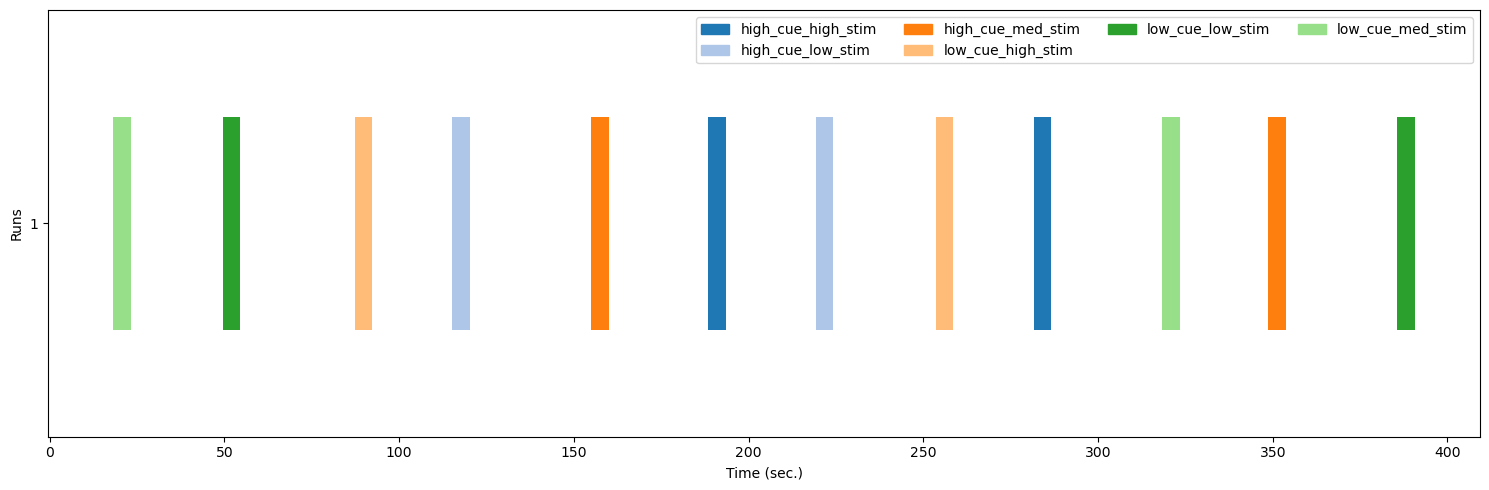

In [157]:
plot_event(events, figsize=(15, 5))
plt.show()

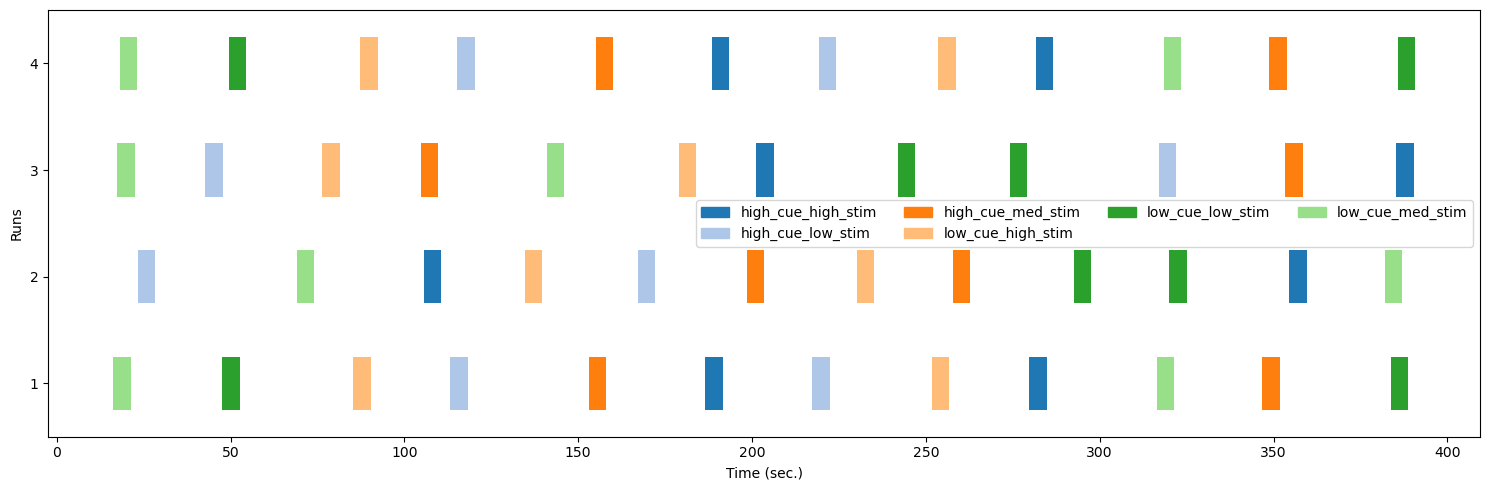

In [158]:
plot_event(event_concat, figsize=(15, 5))
plt.show()

## plot design matrix

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_69356/3845029550.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


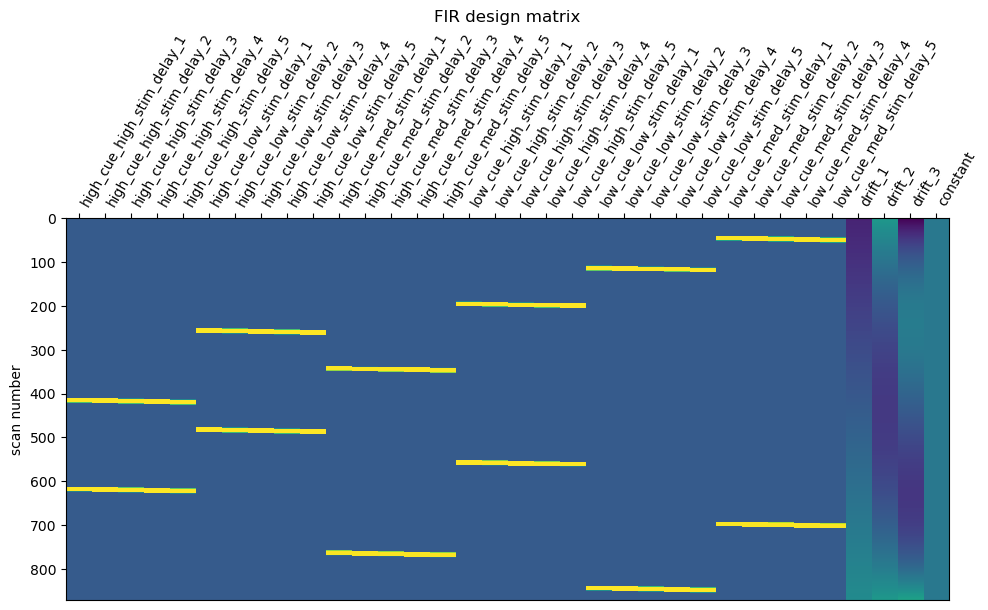

In [102]:
# from nilearn.plotting import plot_design_matrix

# fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

# plot_design_matrix(design_matrix, ax=ax)
# ax.set_title("FIR design matrix", fontsize=12)
# fig.show()

## GLM estimation

In [103]:
# from nilearn.glm.first_level import FirstLevelModel

# fmri_glm = FirstLevelModel( minimize_memory=True)
# fmri_glm = fmri_glm.fit(flist, design_matrices=design_matrices)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affi

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/glm/_utils.py:319: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:98: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/h/miniconda3/envs/spacetop/lib/p

<Axes: label='conditions', ylabel='scan number'>

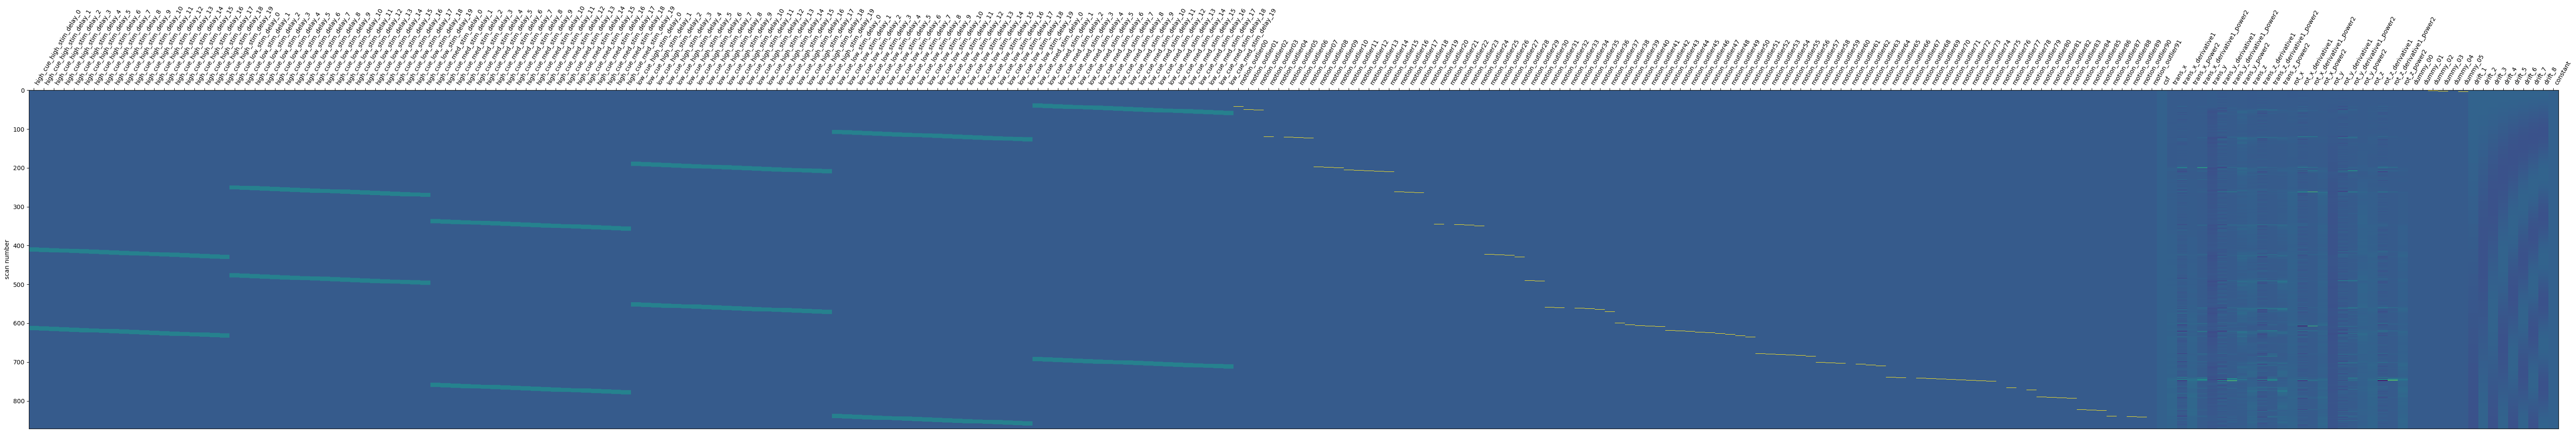

In [455]:
from nilearn.glm.first_level import FirstLevelModel
from nilearn.plotting import plot_contrast_matrix, plot_design_matrix

first_level_model = FirstLevelModel(t_r=0.46, 
                                    hrf_model="fir", 
                                    fir_delays=np.arange(20),
                                    # drift_model="polynomial",
                                    # drift_order=3,
                                    noise_model='ols',
                                    smoothing_fwhm=6,
                                    minimize_memory=False)
first_level_model = first_level_model.fit(fmri_img, 
                                          events=event_concat,
                                          confounds=confounds_concat
                                          )
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)

In [456]:
design_matrix.columns

Index(['high_cue_high_stim_delay_0', 'high_cue_high_stim_delay_1',
       'high_cue_high_stim_delay_2', 'high_cue_high_stim_delay_3',
       'high_cue_high_stim_delay_4', 'high_cue_high_stim_delay_5',
       'high_cue_high_stim_delay_6', 'high_cue_high_stim_delay_7',
       'high_cue_high_stim_delay_8', 'high_cue_high_stim_delay_9',
       ...
       'dummy_05', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5',
       'drift_6', 'drift_7', 'drift_8', 'constant'],
      dtype='object', length=252)

In [457]:
len(first_level_model.design_matrices_)

4

## extract beta

In [459]:
beta_maps = first_level_model.results_[0] 

## for each run

In [430]:
import numpy as np
sessionwise_contrast = []

cue_high_delay_0 = []
cue_high_delay_1 = []
cue_high_delay_2 = []
cue_high_delay_3 = []
cue_high_delay_4 = []
cue_high_delay_5 = []

cue_low_delay_0 = []
cue_low_delay_1 = []
cue_low_delay_2 = []
cue_low_delay_3 = []
cue_low_delay_4 = []
cue_low_delay_5 = []

stim_high_delay_0 = []
stim_high_delay_1 = []
stim_high_delay_2 = []
stim_high_delay_3 = []
stim_high_delay_4 = []
stim_high_delay_5 = []

stim_low_delay_0 = []
stim_low_delay_1 = []
stim_low_delay_2 = []
stim_low_delay_3 = []
stim_low_delay_4 = []
stim_low_delay_5 = []


contrasts_cue_hightGTlow = []
contrasts_stim_highGTlow = []

contrasts_cue_high = []
contrasts_cue_low = []
contrasts_stim_high = []
contrasts_stim_low = []
for i in np.arange(len(first_level_model.design_matrices_)):
    design_matrix = first_level_model.design_matrices_[i]
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }
    print(f"number of columns: {len(design_matrix.columns)}")
    conditions = events.trial_type.unique()
    for condition in conditions:
        contrasts[condition] = np.sum(
            [
                contrasts[name]
                for name in design_matrix.columns
                if name[: len(condition)] == condition
            ],
            0,
        )

# cue high
    contrasts["cue_high_delay_0"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_0", "high_cue_med_stim_delay_0", "high_cue_low_stim_delay_0"]], 0,)
    contrasts["cue_high_delay_1"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_1", "high_cue_med_stim_delay_1", "high_cue_low_stim_delay_1"]],0,)
    contrasts["cue_high_delay_2"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_2", "high_cue_med_stim_delay_2", "high_cue_low_stim_delay_2"]],0,)
    contrasts["cue_high_delay_3"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_3", "high_cue_med_stim_delay_3", "high_cue_low_stim_delay_3"]],0,)
    contrasts["cue_high_delay_4"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_4", "high_cue_med_stim_delay_4", "high_cue_low_stim_delay_4"]],0,)
    contrasts["cue_high_delay_5"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim_delay_5", "high_cue_med_stim_delay_5", "high_cue_low_stim_delay_5"]],0,)
# cue low
    contrasts["cue_low_delay_0"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_0", "low_cue_med_stim_delay_0", "low_cue_low_stim_delay_0"]], 0,)
    contrasts["cue_low_delay_1"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_1", "low_cue_med_stim_delay_1", "low_cue_low_stim_delay_1"]],0,)
    contrasts["cue_low_delay_2"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_2", "low_cue_med_stim_delay_2", "low_cue_low_stim_delay_2"]],0,)
    contrasts["cue_low_delay_3"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_3", "low_cue_med_stim_delay_3", "low_cue_low_stim_delay_3"]],0,)
    contrasts["cue_low_delay_4"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_4", "low_cue_med_stim_delay_4", "low_cue_low_stim_delay_4"]],0,)
    contrasts["cue_low_delay_5"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim_delay_5", "low_cue_med_stim_delay_5", "low_cue_low_stim_delay_5"]],0,)

# stim high
    contrasts["stim_high_delay_0"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_0", "low_cue_high_stim_delay_0"]], 0, )
    contrasts["stim_high_delay_1"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_1", "low_cue_high_stim_delay_1"]], 0, )
    contrasts["stim_high_delay_2"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_2", "low_cue_high_stim_delay_2"]], 0, )
    contrasts["stim_high_delay_3"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_3", "low_cue_high_stim_delay_3"]], 0, )
    contrasts["stim_high_delay_4"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_4", "low_cue_high_stim_delay_4"]], 0, )
    contrasts["stim_high_delay_5"] = np.sum(
        [contrasts[name] for name in ["high_cue_high_stim_delay_5", "low_cue_high_stim_delay_5"]], 0,  )
# stim low
    contrasts["stim_low_delay_0"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_0", "low_cue_low_stim_delay_0"]], 0,)
    contrasts["stim_low_delay_1"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_1", "low_cue_low_stim_delay_1"]], 0,)
    contrasts["stim_low_delay_2"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_2", "low_cue_low_stim_delay_2"]], 0,)
    contrasts["stim_low_delay_3"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_3", "low_cue_low_stim_delay_3"]], 0,)
    contrasts["stim_low_delay_4"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_4", "low_cue_low_stim_delay_4"]], 0,)
    contrasts["stim_low_delay_5"] = np.sum(
        [contrasts[name] for name in ["high_cue_low_stim_delay_5", "low_cue_low_stim_delay_5"]], 0,)


    contrasts["cue_high"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim", "high_cue_med_stim", "high_cue_low_stim"]], 0, )

    contrasts["cue_low"] = np.sum(
        [contrasts[name] for name in 
            ["low_cue_high_stim", "low_cue_med_stim", "low_cue_low_stim"]], 0,)
    
    contrasts["stim_high"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_high_stim", "low_cue_high_stim"]], 0, )

    contrasts["stim_low"] = np.sum(
        [contrasts[name] for name in 
            ["high_cue_low_stim","low_cue_low_stim"]], 0,)
    
    cue_high_delay_0.append(contrasts["cue_high_delay_0"])
    cue_high_delay_1.append(contrasts["cue_high_delay_1"])
    cue_high_delay_2.append(contrasts["cue_high_delay_2"])
    cue_high_delay_3.append(contrasts["cue_high_delay_3"])
    cue_high_delay_4.append(contrasts["cue_high_delay_4"])
    cue_high_delay_5.append(contrasts["cue_high_delay_5"])
    cue_low_delay_0.append(contrasts["cue_low_delay_0"])
    cue_low_delay_1.append(contrasts["cue_low_delay_1"])
    cue_low_delay_2.append(contrasts["cue_low_delay_2"])
    cue_low_delay_3.append(contrasts["cue_low_delay_3"])
    cue_low_delay_4.append(contrasts["cue_low_delay_4"])
    cue_low_delay_5.append(contrasts["cue_low_delay_5"])
    stim_high_delay_0.append(contrasts["stim_high_delay_0"])
    stim_high_delay_1.append(contrasts["stim_high_delay_1"])
    stim_high_delay_2.append(contrasts["stim_high_delay_2"])
    stim_high_delay_3.append(contrasts["stim_high_delay_3"])
    stim_high_delay_4.append(contrasts["stim_high_delay_4"])
    stim_high_delay_5.append(contrasts["stim_high_delay_5"])
    stim_low_delay_0.append(contrasts["stim_low_delay_0"])
    stim_low_delay_1.append(contrasts["stim_low_delay_1"])
    stim_low_delay_2.append(contrasts["stim_low_delay_2"])
    stim_low_delay_3.append(contrasts["stim_low_delay_3"])
    stim_low_delay_4.append(contrasts["stim_low_delay_4"])
    stim_low_delay_5.append(contrasts["stim_low_delay_5"])

    contrasts_cue_high.append(contrasts["cue_high"])
    contrasts_cue_low.append(contrasts["cue_low"])
    contrasts_stim_high.append(contrasts["stim_high"])
    contrasts_stim_low.append(contrasts["stim_low"])
    contrasts_cue_hightGTlow.append(contrasts["cue_high"]  
        - contrasts["cue_low"])
    contrasts_stim_highGTlow.append(contrasts["stim_high"]
        - contrasts["stim_low"])
    
contrasts["cue_high_delay_0"] = cue_high_delay_0
contrasts["cue_high_delay_1"] = cue_high_delay_1
contrasts["cue_high_delay_2"] = cue_high_delay_2
contrasts["cue_high_delay_3"] = cue_high_delay_3
contrasts["cue_high_delay_4"] = cue_high_delay_4
contrasts["cue_high_delay_5"] = cue_high_delay_5

contrasts["cue_low_delay_0"] = cue_low_delay_0
contrasts["cue_low_delay_1"] = cue_low_delay_1
contrasts["cue_low_delay_2"] = cue_low_delay_2
contrasts["cue_low_delay_3"] = cue_low_delay_3
contrasts["cue_low_delay_4"] = cue_low_delay_4
contrasts["cue_low_delay_5"] = cue_low_delay_5

contrasts["stim_high_delay_0"] = stim_high_delay_0
contrasts["stim_high_delay_1"] = stim_high_delay_1
contrasts["stim_high_delay_2"] = stim_high_delay_2
contrasts["stim_high_delay_3"] = stim_high_delay_3
contrasts["stim_high_delay_4"] = stim_high_delay_4
contrasts["stim_high_delay_5"] = stim_high_delay_5

contrasts["stim_low_delay_0"] = stim_low_delay_0
contrasts["stim_low_delay_1"] = stim_low_delay_1
contrasts["stim_low_delay_2"] = stim_low_delay_2
contrasts["stim_low_delay_3"] = stim_low_delay_3
contrasts["stim_low_delay_4"] = stim_low_delay_4
contrasts["stim_low_delay_5"] = stim_low_delay_5

contrasts["cue_high"] = contrasts_cue_high
contrasts["stim_high"] = contrasts_stim_high
contrasts["cue_low"] = contrasts_cue_low
contrasts["stim_low"] = contrasts_stim_low
contrasts["cue_highGTlow"] = contrasts_cue_hightGTlow
contrasts["stim_highGTlow"] = contrasts_stim_highGTlow




number of columns: 168
number of columns: 120
number of columns: 202
number of columns: 148


## gpt suggested

In [461]:
import numpy as np
sessionwise_contrast = []

num_delays = 20

# Initialize empty lists for different conditions and delays
cue_high_delay = [[] for _ in range(num_delays)]
cue_low_delay = [[] for _ in range(num_delays)]
stim_high_delay = [[] for _ in range(num_delays)]
stim_low_delay = [[] for _ in range(num_delays)]

contrasts_cue_high = []
contrasts_cue_low = []
contrasts_stim_high = []
contrasts_stim_low = []
contrasts_cue_hightGTlow = []
contrasts_stim_highGTlow = []

for i in np.arange(len(first_level_model.design_matrices_)):
    design_matrix = first_level_model.design_matrices_[i]
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = {
        column: contrast_matrix[i]
        for i, column in enumerate(design_matrix.columns)
    }
    print(f"number of columns: {len(design_matrix.columns)}")
    conditions = events.trial_type.unique()

    for condition in conditions:
        contrasts[condition] = np.sum(
            [
                contrasts[name]
                for name in design_matrix.columns
                if name.startswith(condition)
            ],
            0,
        )

    # Generate contrast names and append to the respective lists
    for delay in range(num_delays):
        delay_names = [f"high_cue_high_stim_delay_{delay}",
                       f"high_cue_med_stim_delay_{delay}",
                       f"high_cue_low_stim_delay_{delay}"]
        contrasts[f"cue_high_delay_{delay}"] = np.sum([contrasts[name] for name in delay_names if name in contrasts], 0)

        delay_names = [f"low_cue_high_stim_delay_{delay}",
                       f"low_cue_med_stim_delay_{delay}",
                       f"low_cue_low_stim_delay_{delay}"]
        contrasts[f"cue_low_delay_{delay}"] = np.sum([contrasts[name] for name in delay_names if name in contrasts], 0)

        delay_names = [f"high_cue_high_stim_delay_{delay}", f"low_cue_high_stim_delay_{delay}"]
        contrasts[f"stim_high_delay_{delay}"] = np.sum([contrasts[name] for name in delay_names if name in contrasts], 0)

        delay_names = [f"high_cue_low_stim_delay_{delay}", f"low_cue_low_stim_delay_{delay}"]
        contrasts[f"stim_low_delay_{delay}"] = np.sum([contrasts[name] for name in delay_names if name in contrasts], 0)

        cue_high_delay[delay].append(contrasts[f"cue_high_delay_{delay}"])
        cue_low_delay[delay].append(contrasts[f"cue_low_delay_{delay}"])
        stim_high_delay[delay].append(contrasts[f"stim_high_delay_{delay}"])
        stim_low_delay[delay].append(contrasts[f"stim_low_delay_{delay}"])

    contrasts_cue_high.append(contrasts["high_cue_high_stim"])
    contrasts_cue_low.append(contrasts["low_cue_high_stim"])
    contrasts_stim_high.append(contrasts["high_cue_low_stim"])
    contrasts_stim_low.append(contrasts["low_cue_low_stim"])
    contrasts_cue_hightGTlow.append(contrasts["high_cue_high_stim"] - contrasts["low_cue_high_stim"])
    contrasts_stim_highGTlow.append(contrasts["high_cue_low_stim"] - contrasts["low_cue_low_stim"])

# Update the contrasts dictionary with the generated lists
for delay in range(num_delays):
    contrasts[f"cue_high_delay_{delay}"] = cue_high_delay[delay]
    contrasts[f"cue_low_delay_{delay}"] = cue_low_delay[delay]
    contrasts[f"stim_high_delay_{delay}"] = stim_high_delay[delay]
    contrasts[f"stim_low_delay_{delay}"] = stim_low_delay[delay]

contrasts["cue_high"] = contrasts_cue_high
contrasts["cue_low"] = contrasts_cue_low
contrasts["stim_high"] = contrasts_stim_high
contrasts["stim_low"] = contrasts_stim_low
contrasts["cue_highGTlow"] = contrasts_cue_hightGTlow
contrasts["stim_highGTlow"] = contrasts_stim_highGTlow


number of columns: 252
number of columns: 204
number of columns: 286
number of columns: 232


In [462]:
list(contrasts.keys())

['high_cue_high_stim_delay_0',
 'high_cue_high_stim_delay_1',
 'high_cue_high_stim_delay_2',
 'high_cue_high_stim_delay_3',
 'high_cue_high_stim_delay_4',
 'high_cue_high_stim_delay_5',
 'high_cue_high_stim_delay_6',
 'high_cue_high_stim_delay_7',
 'high_cue_high_stim_delay_8',
 'high_cue_high_stim_delay_9',
 'high_cue_high_stim_delay_10',
 'high_cue_high_stim_delay_11',
 'high_cue_high_stim_delay_12',
 'high_cue_high_stim_delay_13',
 'high_cue_high_stim_delay_14',
 'high_cue_high_stim_delay_15',
 'high_cue_high_stim_delay_16',
 'high_cue_high_stim_delay_17',
 'high_cue_high_stim_delay_18',
 'high_cue_high_stim_delay_19',
 'high_cue_low_stim_delay_0',
 'high_cue_low_stim_delay_1',
 'high_cue_low_stim_delay_2',
 'high_cue_low_stim_delay_3',
 'high_cue_low_stim_delay_4',
 'high_cue_low_stim_delay_5',
 'high_cue_low_stim_delay_6',
 'high_cue_low_stim_delay_7',
 'high_cue_low_stim_delay_8',
 'high_cue_low_stim_delay_9',
 'high_cue_low_stim_delay_10',
 'high_cue_low_stim_delay_11',
 'high_c

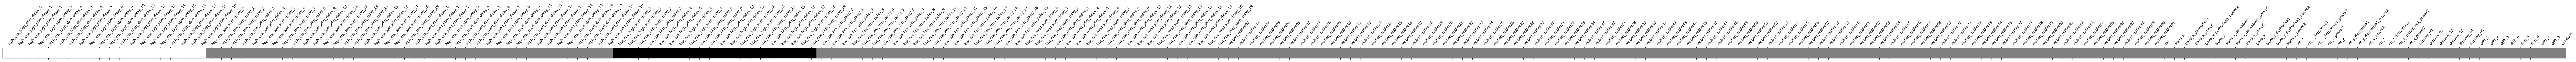

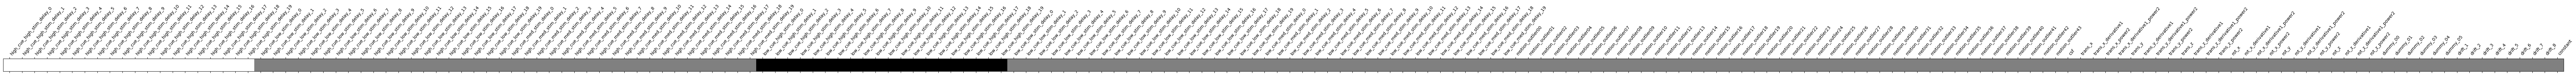

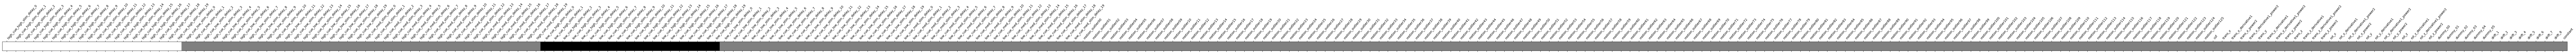

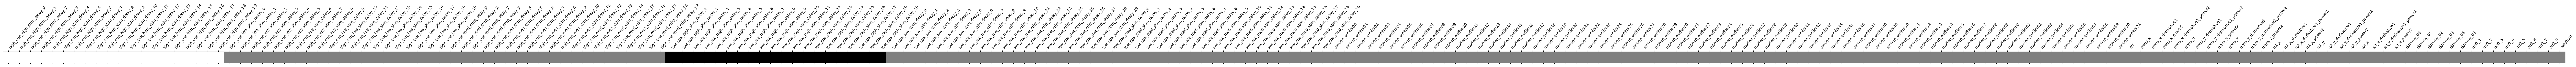

In [463]:
for i in np.arange(len(first_level_model.design_matrices_)):
    plot_contrast_matrix(contrasts["cue_highGTlow"][i], first_level_model.design_matrices_[i])

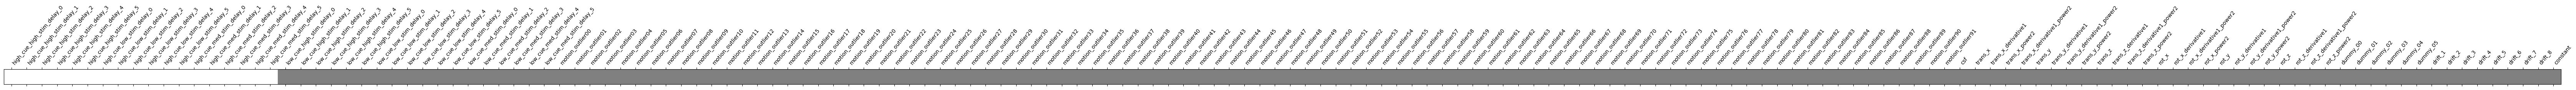

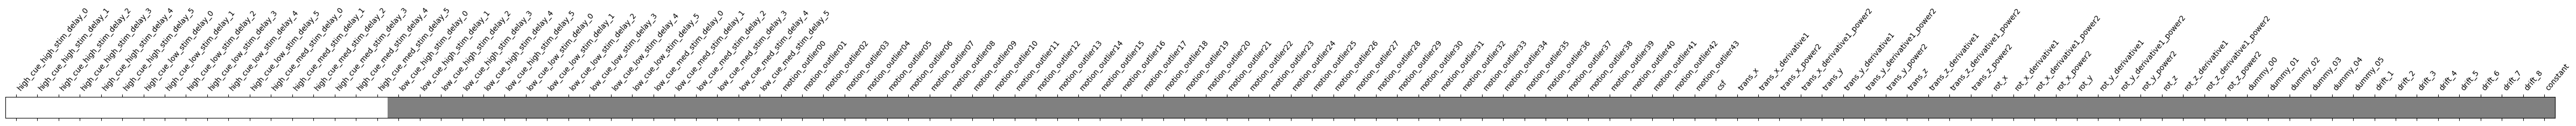

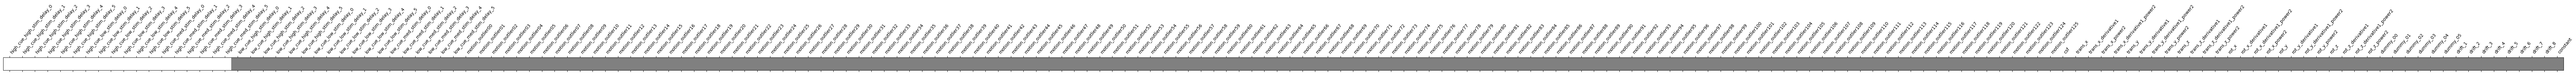

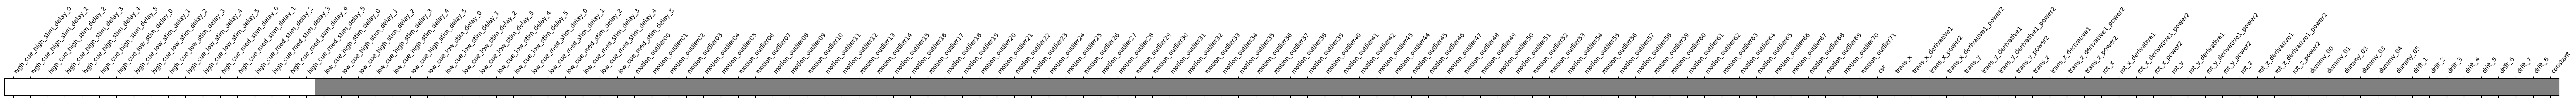

In [405]:
for i in np.arange(len(first_level_model.design_matrices_)):
    plot_contrast_matrix(contrasts["cue_high"][i], first_level_model.design_matrices_[i])

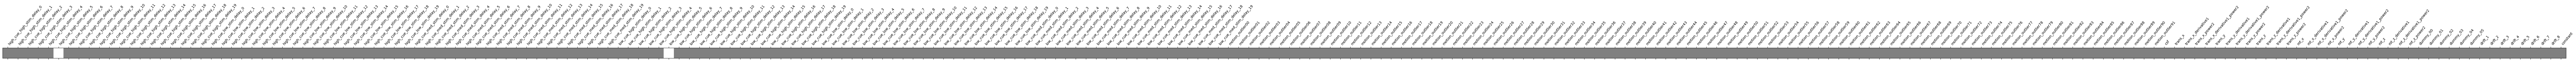

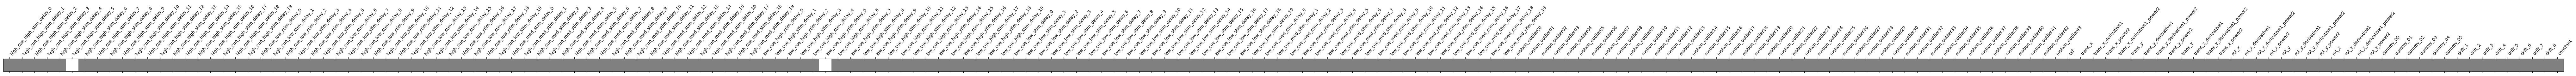

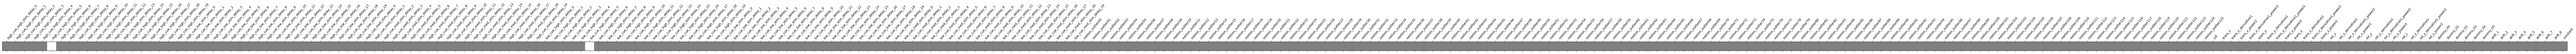

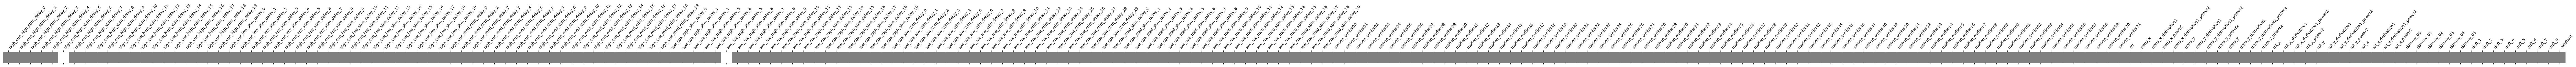

In [464]:
for i in np.arange(len(first_level_model.design_matrices_)):
    plot_contrast_matrix(contrasts["stim_high_delay_5"][i], first_level_model.design_matrices_[i])

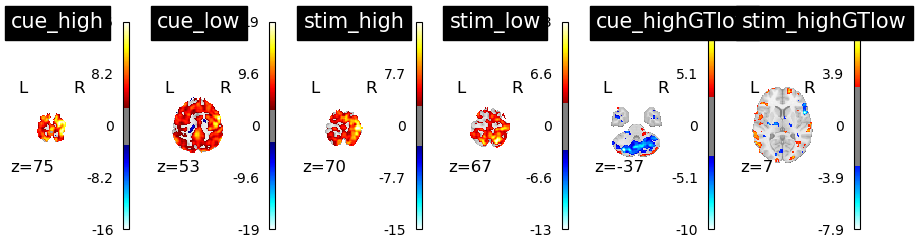

In [465]:
import matplotlib.pyplot as plt

from nilearn.plotting import plot_stat_map
keys_to_subset = ['cue_high', 'cue_low', 'stim_high', 'stim_low', 'cue_highGTlow', 'stim_highGTlow']

subset_dict = dict((key, contrasts[key]) for key in keys_to_subset)


fig = plt.figure(figsize=(11, 3))
for index, (contrast_id, contrast_val) in enumerate(subset_dict.items()):
    ax = plt.subplot(1, len(subset_dict), 1 + index)
    z_map = first_level_model.compute_contrast(
        contrast_val, output_type="z_score"
    )
    plot_stat_map(
        z_map,
        display_mode="z",
        threshold=3.0,
        title=contrast_id,
        axes=ax,
        cut_coords=1,
    )
plt.show()

In [407]:
from nilearn import plotting


def plot_contrast(first_level_model, contrast_dict):
    """Specify, estimate and plot the main contrasts \
        for given a first model."""
    design_matrix = first_level_model.design_matrices_[0]
    # Call the contrast specification within the function
    # contrasts = make_localizer_contrasts(design_matrix)
    plt.figure(figsize=(11, 5))
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrast_dict.items()):
        ax = plt.subplot(1, len(contrast_dict), 1 + index)
        z_map = first_level_model.compute_contrast(
            contrast_val, output_type="z_score"
        )
        plotting.plot_stat_map(
            z_map,
            display_mode="mosaic",
            threshold=3.0,
            title=contrast_id,
            axes=ax,
            cut_coords=1,
            
        )

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_69356/1371663009.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, len(contrast_dict), 1 + index)


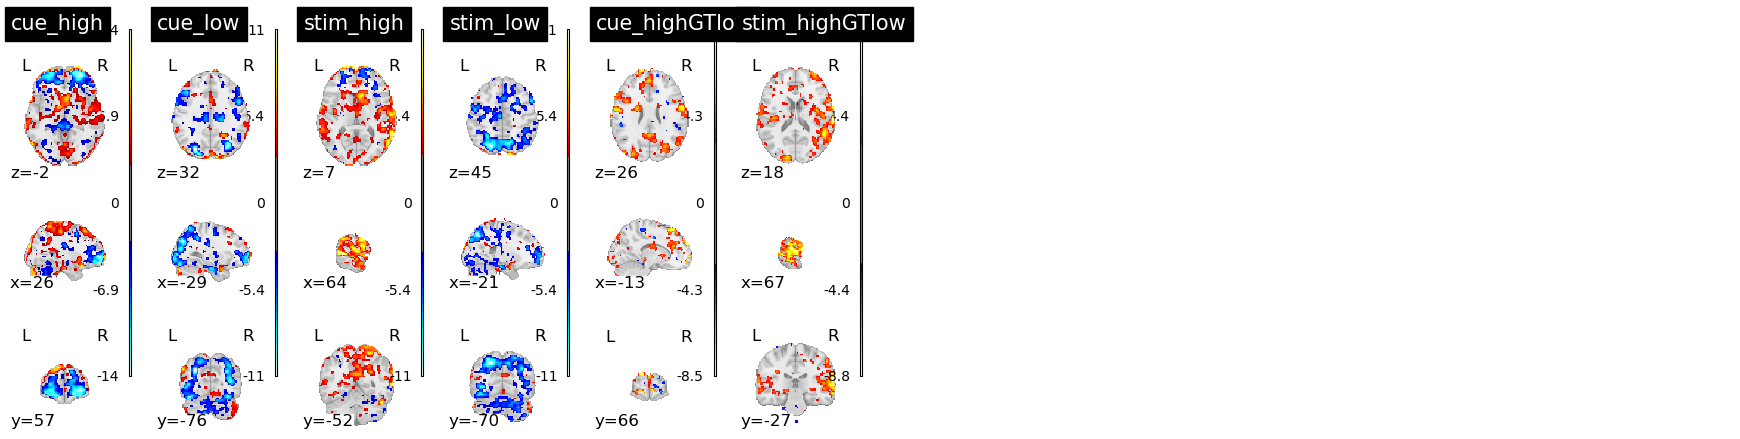

In [408]:
plot_contrast(first_level_model, subset_dict)
plt.show()

In [473]:
stim_high_beta = []
for ind in np.arange(20):
    stim_high_beta_map = first_level_model.compute_contrast(
                contrasts[f"stim_high_delay_{ind}"], output_type="effect_size"
            )
    stim_high_beta.append(stim_high_beta_map)
    

stim_low_beta = []
for ind in np.arange(20):
    stim_low_beta_map = first_level_model.compute_contrast(
                contrasts[f"stim_low_delay_{ind}"], output_type="effect_size"
            )
    stim_low_beta.append(stim_low_beta_map)
    

In [475]:
from nilearn.maskers import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker([(0,0,1)], radius=10)
stim_high_beta_roi = []
for ind in np.arange(len(stim_high_beta)):
    seed_time_series = seed_masker.fit_transform(stim_high_beta[ind])
    stim_high_beta_roi.append(seed_time_series)

stim_low_beta_roi = []
for ind in np.arange(len(stim_low_beta)):
    seed_time_series = seed_masker.fit_transform(stim_low_beta[ind])
    stim_low_beta_roi.append(seed_time_series)
    

In [476]:
len(np.array(stim_low_beta_roi).flatten())

20

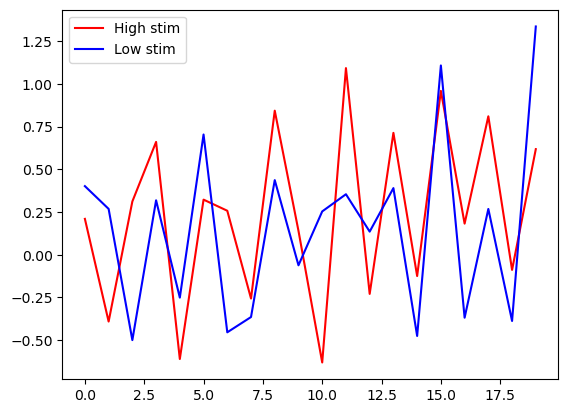

In [477]:
plt.plot(np.array(stim_high_beta_roi).flatten(), color='red', label='High stim')
plt.plot(np.array(stim_low_beta_roi).flatten(), color='blue', label='Low stim')
plt.legend()

plt.show()

# low cue high cue

In [478]:
cue_high_beta = []
for ind in np.arange(20):
    cue_high_beta_map = first_level_model.compute_contrast(
                contrasts[f"cue_high_delay_{ind}"], output_type="effect_size"
            )
    cue_high_beta.append(cue_high_beta_map)
    

cue_low_beta = []
for ind in np.arange(20):
    cue_low_beta_map = first_level_model.compute_contrast(
                contrasts[f"cue_low_delay_{ind}"], output_type="effect_size"
            )
    cue_low_beta.append(cue_low_beta_map)
    

from nilearn.maskers import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker([(0,0,1)], radius=10)
cue_high_beta_roi = []
for ind in np.arange(len(cue_high_beta)):
    seed_time_series = seed_masker.fit_transform(cue_high_beta[ind])
    cue_high_beta_roi.append(seed_time_series)

cue_low_beta_roi = []
for ind in np.arange(len(cue_low_beta)):
    seed_time_series = seed_masker.fit_transform(cue_low_beta[ind])
    cue_low_beta_roi.append(seed_time_series)
    

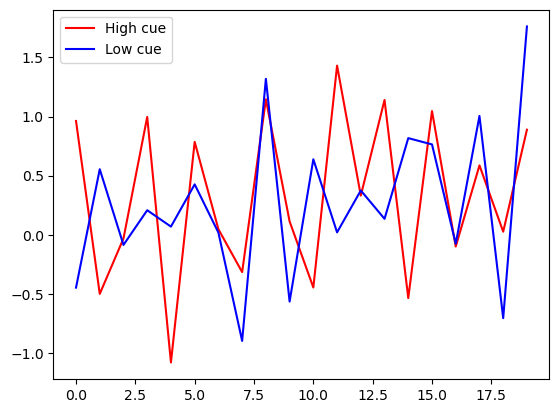

In [479]:
plt.plot(np.array(cue_high_beta_roi).flatten(), color='red', label='High cue')
plt.plot(np.array(cue_low_beta_roi).flatten(), color='blue', label='Low cue')
plt.legend()

plt.show()

## get largest cluster

In [270]:
from nilearn.maskers import NiftiSpheresMasker
from nilearn.reporting import get_clusters_table

table = get_clusters_table(z_map, stat_threshold=3.1, cluster_threshold=20)
table.set_index("Cluster ID", drop=True)
table.head()

# get the 6 largest clusters' max x, y, and z coordinates
coords = table.loc[range(1, 7), ["X", "Y", "Z"]].values

## beta coefficient

In [271]:
predicted_time_series_first_run = first_level_model.predicted[0]

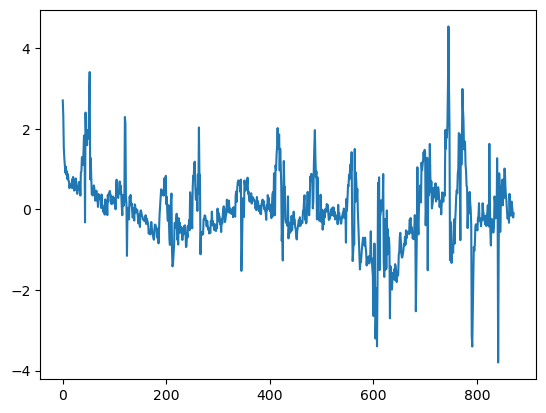

In [272]:
from nilearn.maskers import NiftiSpheresMasker
seed_masker = NiftiSpheresMasker([(0,0,1)], radius=10)
seed_time_series = seed_masker.fit_transform(predicted_time_series_first_run)
plt.plot(seed_time_series)

In [273]:
observed_timeseries = masker.fit_transform(fmri_img[0])
predicted_timeseries = masker.fit_transform(first_level_model.predicted[0])

[NiftiLabelsMasker.wrapped] loading data from /Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex/MNIvolumetric/Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz
[Memory]1021.5s, 17.0min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex/MNIvolumetric/Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x165f11150>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x292446ad0>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_con

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_labels_masker.py:585: UserWarning: Persisting input arguments took 9.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  region_signals, labels_ = self._cache(


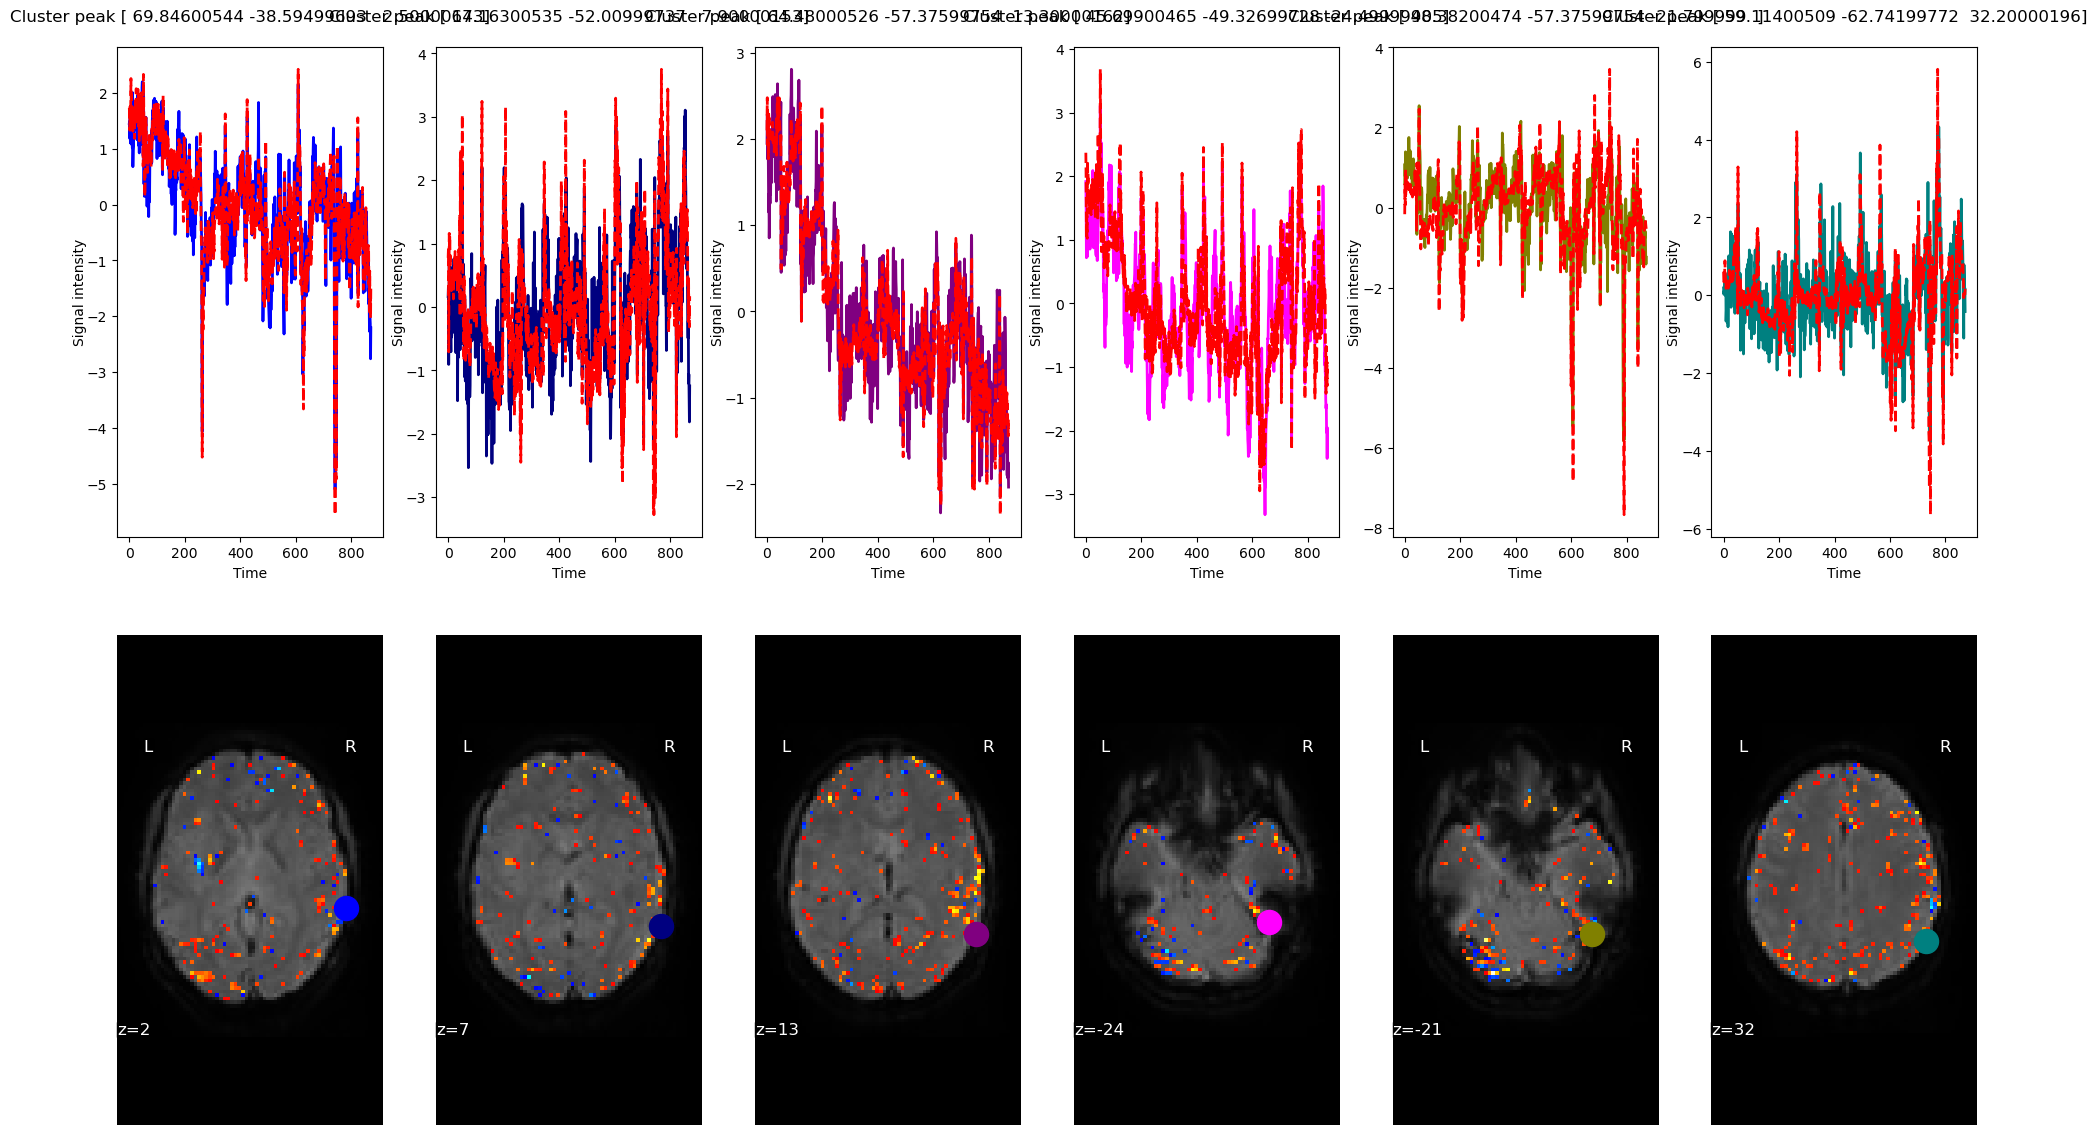

In [257]:
import matplotlib.pyplot as plt
mean_img = image.mean_img(fmri_img[0])
# colors for each of the clusters
colors = ["blue", "navy", "purple", "magenta", "olive", "teal"]
# plot the time series and corresponding locations
fig1, axs1 = plt.subplots(2, 6)
for i in range(6):
    # plotting time series
    axs1[0, i].set_title(f"Cluster peak {coords[i]}\n")
    axs1[0, i].plot(observed_timeseries[:, i], c=colors[i], lw=2)
    axs1[0, i].plot(predicted_timeseries[:, i], c="r", ls="--", lw=2)
    axs1[0, i].set_xlabel("Time")
    axs1[0, i].set_ylabel("Signal intensity", labelpad=0)
    # plotting image below the time series
    roi_img = plotting.plot_stat_map(
        z_map,
        cut_coords=[coords[i][2]],
        threshold=3.1,
        figure=fig1,
        axes=axs1[1, i],
        display_mode="z",
        colorbar=False,
        bg_img=mean_img,
    )
    roi_img.add_markers([coords[i]], colors[i], 300)
fig1.set_size_inches(24, 14)

## condition difference timewise extraction

In [285]:
def extract_timecourse_condition_per_beh(behdf, column_name,time_series, prior_event_sec, after_event_sec):
    """extract_timecourse_condition

    Args:
        behdf (pd.DataFrame): dataframe with onset time and condition type metadata
        column_name (str): Which column to reference from the behavioral dataframe
        level_name (str): which level from a given factor?
        time_series (np.array): array from masker extraction 
        prior_event_sec (int): how many seconds do you want to extract prior to event onset?
        after_event_sec (int): how many seconds to you want to extract after event onset?
        # TR_timepoints ([type]): [description]

    Returns:
        results_interval: np.array of trial x timepoints values
    """
    TR=0.46
    rounded_intervals = np.round(behdf[column_name]).astype(int)
    result_intervals = []

    for rounded_index in rounded_intervals:
        # start_index = max(0, rounded_index - np.round(int(np.abs(prior_event_sec))/TR))  # Ensure the start index is not negative
        # end_index = min(len(time_series), rounded_index + np.round(int(after_event_sec)/TR) + 1)  # Add 10 data points (+1 to include the end index)
       
        start_index = max(0, int(rounded_index) - int(np.round(prior_event_sec / TR)))
        end_index = min(len(time_series), int(rounded_index) + int(np.round(after_event_sec / TR)) )
        interval = time_series[start_index:end_index]
        result_intervals.append(interval)

    result_intervals = np.vstack(result_intervals)
    return result_intervals


In [286]:
highstim = extract_timecourse_condition_per_beh(event_df[(event_df['trial_type']=='stimulus') & (event_df['stimtype'] == 'high_stim')],
                                              column_name='onset', 
                                              time_series=observed_timeseries.T[0], 
                                              prior_event_sec=-3, 
                                              after_event_sec=10)

lowstim = extract_timecourse_condition_per_beh(event_df[(event_df['trial_type']=='stimulus') & (event_df['stimtype'] == 'low_stim')],
                                              column_name='onset', 
                                              time_series=observed_timeseries.T[0], 
                                              prior_event_sec=-3, 
                                              after_event_sec=10)


In [282]:
# observed_timeseries = masker.fit_transform(fmri_img[0])
# predicted_timeseries = masker.fit_transform(first_level_model.predicted[0])



# rounded_intervals = np.round(event_df[(event_df['trial_type']=='stimulus') & (event_df['stimtype'] == 'high_stim')].onset).astype(int)
# result_intervals = []

# for rounded_index in rounded_intervals:
#     start_index = max(0, rounded_index - 5)  # Ensure the start index is not negative
#     end_index = min(len(observed_timeseries.T[0]), rounded_index + int(20) + 1)  # Add 10 data points (+1 to include the end index)
#     print(start_index,end_index)
#     interval = observed_timeseries.T[0][start_index:end_index]
#     result_intervals.append(interval)

# result_intervals = np.vstack(result_intervals)
# result_intervals.shape



[NiftiLabelsMasker.wrapped] loading data from /Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex/MNIvolumetric/Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz
[Memory]1347.0s, 22.4min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex/MNIvolumetric/Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz
[Memory]1357.7s, 22.6min: Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
82 108
183 209
249 275
277 303


(4, 26)

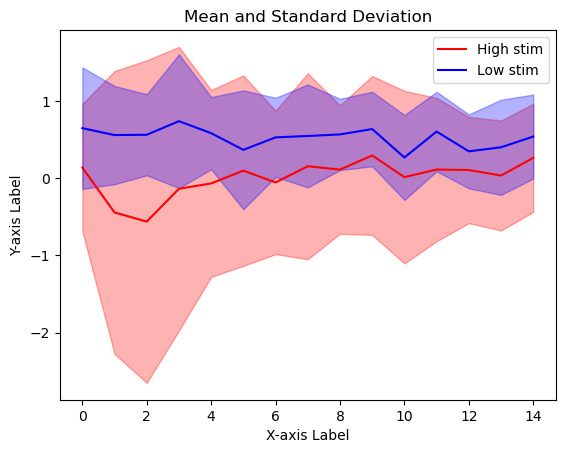

In [291]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'high_stim' is your numpy array with shape (4, 26)
# Calculate the mean and standard deviation along the axis containing the different lines (axis=0)
Hmean_line = np.mean(highstim, axis=0)
Hstd_line = np.std(highstim, axis=0)

Lmean_line = np.mean(lowstim, axis=0)
Lstd_line = np.std(lowstim, axis=0)


fig, ax = plt.subplots()


ax.plot(Hmean_line, color='red', label='High stim')
ax.fill_between(range(highstim.shape[1]), Hmean_line - Hstd_line, 
                Hmean_line + Hstd_line, 
                alpha=0.3, color='red')

ax.plot(Lmean_line, color='blue', label='Low stim')
ax.fill_between(range(lowstim.shape[1]), Lmean_line - Lstd_line, 
                Lmean_line + Lstd_line, 
                alpha=0.3, color='blue')

# Add legend and labels
ax.legend()
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Mean and Standard Deviation')

# Show the plot
plt.show()


## extract time series from ROI

In [224]:
subcortex_dir = '/Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex'
subcortex = join(subcortex_dir,'MNIvolumetric', 'Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz')
subcortex_label = join(subcortex_dir,  'Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_label.txt')
labels = pd.read_csv(subcortex_label, sep='\t', header=None)
template = load_mni152_template(resolution=3)
# subcortex_atlas = image.load_img(subcortex)
# subcortex_img = image.resample_to_img(subcortex_atlas, template, interpolation='nearest') #, target_affine=ref_img.affine, target_shape=ref_img.shape)
# nifti_masker = maskers.NiftiMasker(mask_img=masking.compute_epi_mask(template))


masker = maskers.NiftiLabelsMasker(
    labels_img=subcortex,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

In [227]:
fmri_img

In [229]:
observed_timeseries = masker.fit_transform(flist, 
                                           confounds=confounds_concat  )
# predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

[NiftiLabelsMasker.wrapped] loading data from /Users/h/Documents/projects_local/Tian2020MSA/3T/Cortex-Subcortex/MNIvolumetric/Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz


ValueError: Field of view of image #1 is different from reference FOV.
Reference affine:
array([[   2.68300009,    0.        ,    0.        ,  -96.5       ],
       [   0.        ,    2.68300009,    0.        , -132.5       ],
       [   0.        ,    0.        ,    2.70000005,  -78.5       ],
       [   0.        ,    0.        ,    0.        ,    1.        ]])
Image affine:
array([[ 2.68299913e+00,  2.13050842e-03, -1.22094154e-03,
        -9.66311340e+01],
       [-2.12728977e-03,  2.68298960e+00,  7.23832846e-03,
        -1.32657303e+02],
       [ 1.21897459e-03, -7.19177723e-03,  2.69999003e+00,
        -7.82624588e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
Reference shape:
(73, 86, 73)
Image shape:
(73, 86, 73, 872)
